In [2]:
%pylab inline
import h5py 
import programas as pg
import pandas as pd
import grispy as gsp

Populating the interactive namespace from numpy and matplotlib


In [2]:
file = h5py.File('/mnt/projects/bias_mock/galaxies/galpos_RedSample_1e-03.hdf5','r')
pos = file['Subhalo/SubhaloPos'][()]

In [3]:
def positions_to_density_field(pos, box_size, grid_size):
    # Determina el tamaño de cada celda de la cuadrícula
    cell_size = box_size / grid_size
    
    # Inicializa el campo de densidad
    density_field = np.zeros((grid_size, grid_size, grid_size))
    
    # Determina las coordenadas de celda para cada posición
    cell_indices = np.floor(pos / cell_size).astype(int)
    
    # Aumenta la densidad en cada celda
    for index in cell_indices:
        density_field[tuple(index)] = density_field[tuple(index)] + 1 
    
    # Normaliza la densidad
    density_field = density_field / (cell_size**3)
    
    return density_field

## Transformo mis posiciones de galaxias a campo de densidad

In [4]:
density_field = positions_to_density_field(pos, box_size=1440.0, grid_size=540)

## Ahora voy a hacer un Fourier-smooth sobre el campo

In [5]:
from scipy.fftpack import fftn, ifftn

def fourier_smoothing(field, sigma):
    # Calcular la transformada de Fourier tridimensional del campo de densidad
    field_fft = fftn(field)
    
    # Calcular el cuadrado de las magnitudes de los vectores de frecuencia
    k_squared = np.sum(np.square(np.meshgrid(*[np.fft.fftfreq(n, d=1) for n in field.shape])), axis=0)
    
    # Aplicar un filtro gaussiano en el espacio de Fourier para suavizar
    gaussian_filter = np.exp(-0.5 * (sigma * k_squared)**2)
    smoothed_field_fft = field_fft * gaussian_filter
    
    # Calcular la transformada inversa de Fourier para obtener el campo suavizado
    smoothed_field = np.real(ifftn(smoothed_field_fft))
    
    return smoothed_field

In [6]:
smoothed_field = fourier_smoothing(density_field,30)

In [38]:
#np.save('smoothed_field_mio.npy', smoothed_field)

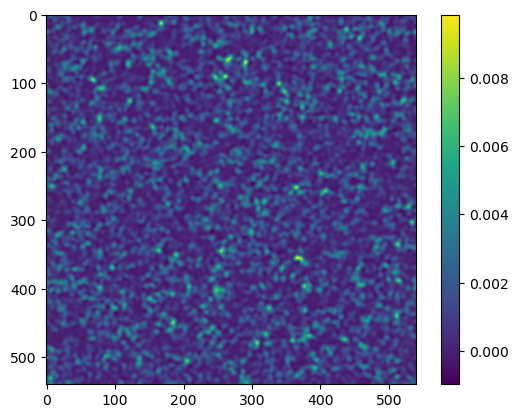

In [7]:
sigma = 100

field_fft = fftn(density_field)
    
# Calcular el cuadrado de las magnitudes de los vectores de frecuencia
k_squared = np.sum(np.square(np.meshgrid(*[np.fft.fftfreq(n, d=1) for n in density_field.shape])), axis=0)
    
# Aplicar un filtro gaussiano en el espacio de Fourier para suavizar
gaussian_filter = np.exp(-0.5 * (sigma * k_squared)**2)
smoothed_field_fft = field_fft * gaussian_filter
    
# Calcular la transformada inversa de Fourier para obtener el campo suavizado
smoothed_field = np.real(ifftn(smoothed_field_fft))

plt.imshow(smoothed_field[0])
plt.colorbar()

## Convolucion con mi funcion ventana

In [8]:
from scipy.signal import fftconvolve

circle_radio = 1
bines_grid = 540

campo_extendido = np.pad(density_field,  [(circle_radio, circle_radio)]*3, mode='wrap')
kernel_radio = circle_radio + 1
kernel = pg.generate_circle_matrix_3d(bines_grid, kernel_radio, dim=3)
    # normalize the kernel
kernel = kernel/np.sum(kernel)

    # Realizar la convolución
campo_convolucionado = fftconvolve(campo_extendido, kernel, mode='same')
    
center_field = campo_convolucionado[circle_radio:circle_radio+bines_grid,
                                    circle_radio:circle_radio+bines_grid,
                                    circle_radio:circle_radio+bines_grid]

In [9]:
#np.save('smoothed_field_1e-03.npy', center_field)

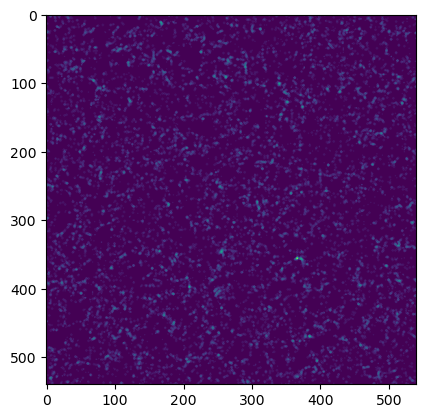

In [10]:
plt.imshow(center_field[0])

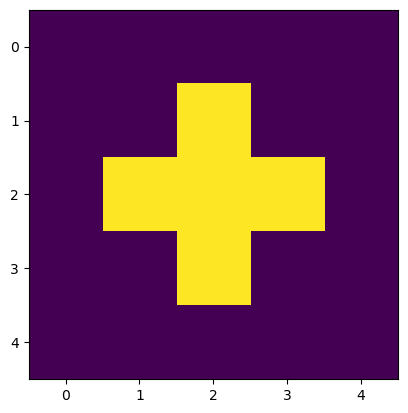

In [60]:
plt.imshow(kernel[2])

In [7]:
stop

NameError: name 'stop' is not defined

In [5]:
np.save('density_field_mio.npy', density_field)
#df = pd.read_csv('perfiles_interp_density_field_mio_pruebas.csv')

In [58]:
rhomean = len(pos)/(1440**3)
delta = (df['media']-rhomean)/rhomean

In [59]:
delta_mio = (df['media']-rhomean)/rhomean

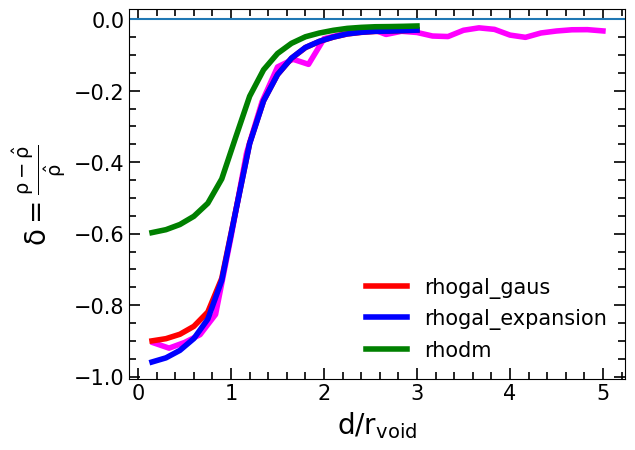

In [60]:
plt.plot(df['distance'],delta_mio,color='magenta',lw=4)

df = pd.read_csv('perfiles_interp_rhogal_eul_bias_gaus.csv')
dist = df['distance']
mediana = df['mediana']
q25 = df['q25']
q75 = df['q75']
mean = df['media']

field = np.load('/mnt/projects/bias_mock/rhogal_eul_bias_gaus.npy')
rhomean = np.mean(field)
delta = (mean - rhomean)/rhomean
delta_q25 = (q25 - rhomean)/rhomean
delta_q75 = (q75 - rhomean)/rhomean

plt.plot(dist,delta,color='red',lw=4,label='rhogal_gaus')
#plt.fill_between(dist,delta_q25,delta_q75,color='red',alpha=.3)

df = pd.read_csv('perfiles_interp_rhogal_eul_bias_expansion.csv')
dist = df['distance']
mediana = df['mediana']
q25 = df['q25']
q75 = df['q75']
mean = df['media']

field = np.load('/mnt/projects/bias_mock/rhogal_eul_bias_expansion.npy')
rhomean = np.mean(field)
delta = (mean - rhomean)/rhomean
delta_q25 = (q25 - rhomean)/rhomean
delta_q75 = (q75 - rhomean)/rhomean

plt.plot(dist,delta,color='blue',lw=4,label='rhogal_expansion')
#plt.fill_between(dist,delta_q25,delta_q75,color='blue',alpha=.3)

df = pd.read_csv('perfiles_interp_rhodm_eul.csv')
dist = df['distance']
mediana = df['mediana']
q25 = df['q25']
q75 = df['q75']
mean = df['media']

field = np.load('/mnt/projects/bias_mock/rhodm_eul.npy')
rhomean = np.mean(field)
delta = (mean - rhomean)/rhomean
delta_q25 = (q25 - rhomean)/rhomean
delta_q75 = (q75 - rhomean)/rhomean

plt.plot(dist,delta,color='green',lw=4,label='rhodm')
#plt.fill_between(dist,delta_q25,delta_q75,color='green',alpha=.3)

plt.legend(frameon=False,fontsize=15,loc='lower right')
plt.tick_params('both',length=5,width=1.2,which='minor',direction='in',right='on',top='on')
plt.tick_params('both',length=8,width=1.2,which='major',direction='in',right='on',top='on')
plt.tick_params(labelsize=15)
plt.minorticks_on()

plt.xlabel('$ \\rm d/r_{void} $', size=20)
plt.ylabel('$ \\rm \\delta=\\frac{\\rho-\\hat{\\rho}}{\\hat{\\rho}} $',size=20)

plt.axhline(y = 0)

In [ ]:
from scipy.fftpack import fftn, ifftn

def fourier_smoothing(field, sigma):
    # Calcular la transformada de Fourier tridimensional del campo de densidad
    field_fft = fftn(field)
    
    # Calcular el cuadrado de las magnitudes de los vectores de frecuencia
    k_squared = np.sum(np.square(np.meshgrid(*[np.fft.fftfreq(n, d=1) for n in field.shape])), axis=0)
    
    # Aplicar un filtro gaussiano en el espacio de Fourier para suavizar
    gaussian_filter = np.exp(-0.5 * (sigma * k_squared)**2)
    smoothed_field_fft = field_fft * gaussian_filter
    
    # Calcular la transformada inversa de Fourier para obtener el campo suavizado
    smoothed_field = np.real(ifftn(smoothed_field_fft))
    
    return smoothed_field

In [ ]:
smoothed_field = fourier_smoothing(density_field,30)

In [4]:
file = h5py.File('/mnt/projects/bias_mock/galaxies/galpos_RedSample_1e-03.hdf5','r')
pos = file['Subhalo/SubhaloPos'][()]

In [5]:
density_field = positions_to_density_field(pos, box_size=1440.0, grid_size=540)

In [7]:
field_fft = fftn(density_field)

In [11]:
k_squared = np.sum(np.square(np.meshgrid(*[np.fft.fftfreq(n, d=1) for n in density_field.shape])), axis=0)

In [13]:
k_squared

array([[[0.00000000e+00, 3.42935528e-06, 1.37174211e-05, ...,
         3.08641975e-05, 1.37174211e-05, 3.42935528e-06],
        [3.42935528e-06, 6.85871056e-06, 1.71467764e-05, ...,
         3.42935528e-05, 1.71467764e-05, 6.85871056e-06],
        [1.37174211e-05, 1.71467764e-05, 2.74348422e-05, ...,
         4.45816187e-05, 2.74348422e-05, 1.71467764e-05],
        ...,
        [3.08641975e-05, 3.42935528e-05, 4.45816187e-05, ...,
         6.17283951e-05, 4.45816187e-05, 3.42935528e-05],
        [1.37174211e-05, 1.71467764e-05, 2.74348422e-05, ...,
         4.45816187e-05, 2.74348422e-05, 1.71467764e-05],
        [3.42935528e-06, 6.85871056e-06, 1.71467764e-05, ...,
         3.42935528e-05, 1.71467764e-05, 6.85871056e-06]],

       [[3.42935528e-06, 6.85871056e-06, 1.71467764e-05, ...,
         3.42935528e-05, 1.71467764e-05, 6.85871056e-06],
        [6.85871056e-06, 1.02880658e-05, 2.05761317e-05, ...,
         3.77229081e-05, 2.05761317e-05, 1.02880658e-05],
        [1.71467764e-05, 